In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pingouin as pg
import matplotlib as mpl
from matplotlib.offsetbox import AnchoredText
import warnings

from src import data

from netneurotools import metrics
    # https://netneurotools.readthedocs.io/en/latest/, pip install netneurotools does not work for me
    # I downloaded the repository and I am using the local copy

%matplotlib inline

!date -I

2024-04-11


## Settings

In [2]:
parcellations = {"DKT","MNI-HCP-MMP1"} # MNI-HCP-MMP1 is another name for Glasser parcellation

# following ROIs are not present in enigma with DKT parcellation,
# so it should be deleted from responses to have matching dimensions
ids_to_delete_in_dkt = [37,3] 

# set parecallation to use for structural connectivity
# availible parcellations listed above
PARCELLATION =  "MNI-HCP-MMP1"
AMPLITUDE_MASK_SAME_AS_PROBABILITY_MASK = False

# True for 50 ms version, 200 ms version otherwise
FTRACT_SHORT = False

if PARCELLATION not in parcellations:
    print(f"Selected parcellation {PARCELLATION} not in availible parcellations!")

## Load data

### Load F-TRACT data

In [3]:
# F-TRACT dataset is availible in several parcellations, select and load the one defined above
response_probability, response_amplitude, n_stim, n_impl, ftract_labels = data.load_ftract(PARCELLATION,short=FTRACT_SHORT)

if PARCELLATION == "DKT":
    for a in [0,1]:
        response_probability = np.delete(response_probability,ids_to_delete_in_dkt,axis=a)
        response_amplitude = np.delete(response_amplitude,ids_to_delete_in_dkt,axis=a)
        n_stim = np.delete(n_stim,ids_to_delete_in_dkt,axis=a)
        n_impl = np.delete(n_impl,ids_to_delete_in_dkt,axis=a)

mask = np.logical_and(n_stim > 100, n_impl > 5)

if AMPLITUDE_MASK_SAME_AS_PROBABILITY_MASK:
    mask_amp = mask
else:
    mask_amp = (n_stim*response_probability)>=100

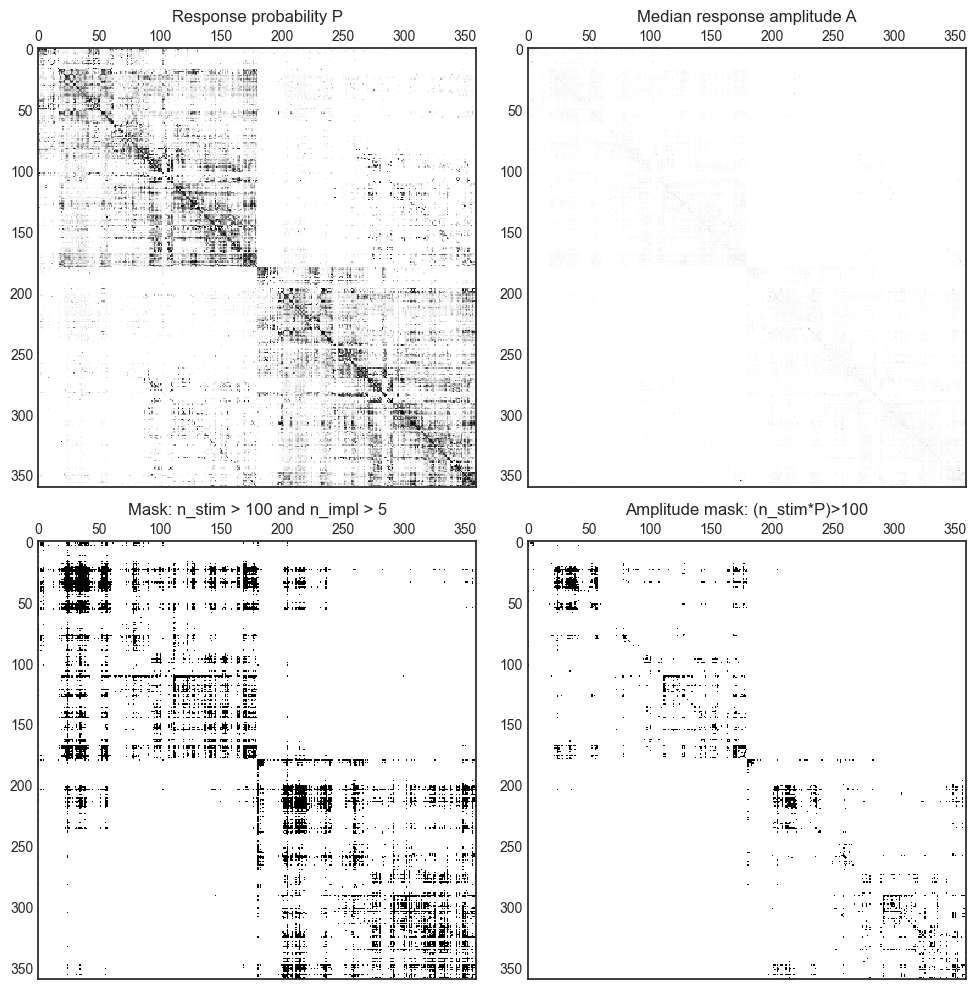

In [4]:
plt.rcParams['figure.figsize'] = [10, 10]
plt.style.use('seaborn-v0_8-white')

fig, axs = plt.subplots(2, 2, tight_layout=True)
axs[0,0].matshow(response_probability)
axs[0,0].set_title("Response probability P")
axs[0,1].matshow(response_amplitude)
axs[0,1].set_title("Median response amplitude A")
axs[1,0].matshow(mask)
axs[1,0].set_title("Mask: n_stim > 100 and n_impl > 5")
axs[1,1].matshow(mask_amp)

if AMPLITUDE_MASK_SAME_AS_PROBABILITY_MASK:
    axs[1,1].set_title("Amplitude mask same as mask")
else:
    axs[1,1].set_title("Amplitude mask: (n_stim*P)>100")

### Load structural connectivity data

In [5]:
SC_matrices = []

if PARCELLATION == "DKT":
    SC_matrices = data.load_set_of_DKT_matrices_for_ftract(ftract_labels,ids_to_delete_in_dkt)
    ED = None

elif PARCELLATION == "MNI-HCP-MMP1":
    ED = data.glasser_roi_distances(ftract_labels=ftract_labels)
    SC_matrices = data.load_set_of_glasser_matrices_for_ftract(ftract_labels,ED)

number_of_SC = len(SC_matrices)

  regionName                   regionLongName regionIdLabel LR region Lobe  \
0       V1_L          Primary_Visual_Cortex_L           1_L  L     V1  Occ   
1      MST_L  Medial_Superior_Temporal_Area_L           2_L  L    MST  Occ   
2       V6_L              Sixth_Visual_Area_L           3_L  L     V6  Occ   
3       V2_L             Second_Visual_Area_L           4_L  L     V2  Occ   
4       V3_L              Third_Visual_Area_L           5_L  L     V3  Occ   

                                     cortex  regionID  Cortex_ID       x-cog  \
0                            Primary_Visual         1          1  100.491589   
1  MT+_Complex_and_Neighboring_Visual_Areas         2          5  132.416667   
2                      Dorsal_Stream_Visual         3          3  104.543112   
3                              Early_Visual         4          2  102.236656   
4                              Early_Visual         5          2  107.926111   

       y-cog       z-cog  volmm ftract_labels  
0 

/home/katterrina/fi_muni/0_diplomka/src/data.py:317: RuntimeWarning: divide by zero encountered in log
  SC_matrices_mica.append(("Mica-Mics_rh",SC_W_M, SC_L_M,np.log(SC_W_M)))
/home/katterrina/fi_muni/0_diplomka/src/data.py:320: RuntimeWarning: divide by zero encountered in log
  SC_matrices_mica.append(("Mica-Mics_simple",SC_W_M_mean, SC_L_M_mean,np.log(SC_W_M_mean)))
/home/katterrina/fi_muni/0_diplomka/src/data.py:324: RuntimeWarning: divide by zero encountered in log
  SC_matrices_mica.append(("Mica-Mics_dist",SC_W_M_dist, SC_L_M_dist,np.log(SC_W_M_dist)))


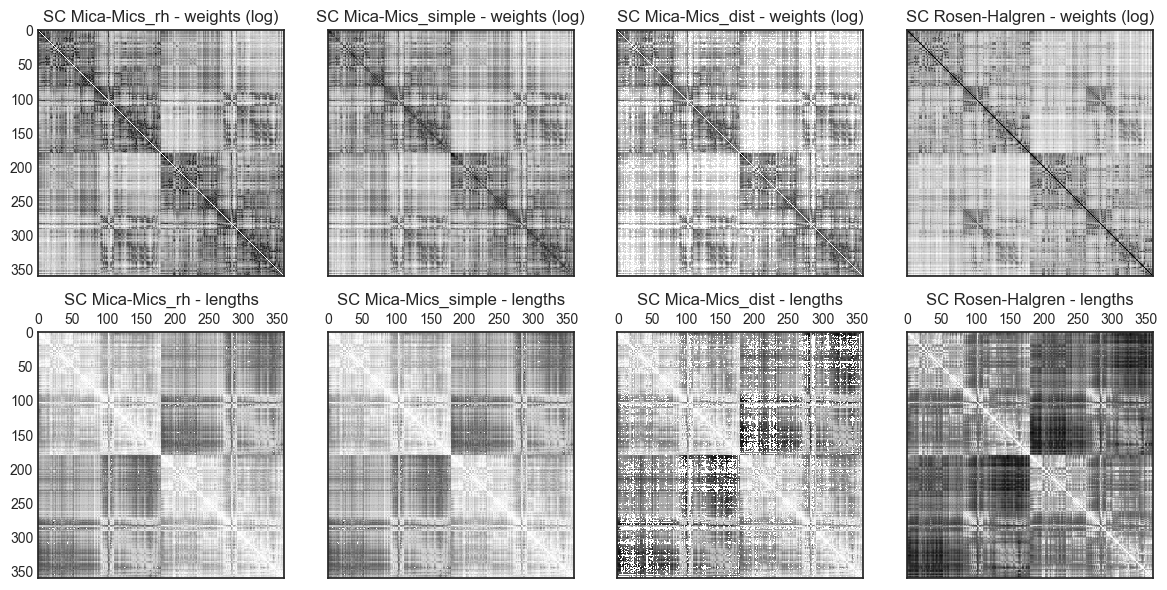

In [6]:
plt.rcParams['figure.figsize'] = [3*number_of_SC,6]
plt.style.use('seaborn-v0_8-white')

fig, axs = plt.subplots(2,number_of_SC, tight_layout=True,sharex=True,sharey=True)

for i, stat_data in enumerate(SC_matrices):
    name, SC_W, SC_L, SC_W_log = stat_data

    axs[0,i].matshow(SC_W_log)
    axs[0,i].set_title(f"SC {name} - weights (log)")

    if SC_L is not None:
        axs[1,i].matshow(SC_L)
        axs[1,i].set_title(f"SC {name} - lengths")

    else:
        axs[1,i].matshow(np.zeros(SC_W.shape))
        axs[1,i].set_title(f"SC {name} - NO lengths")

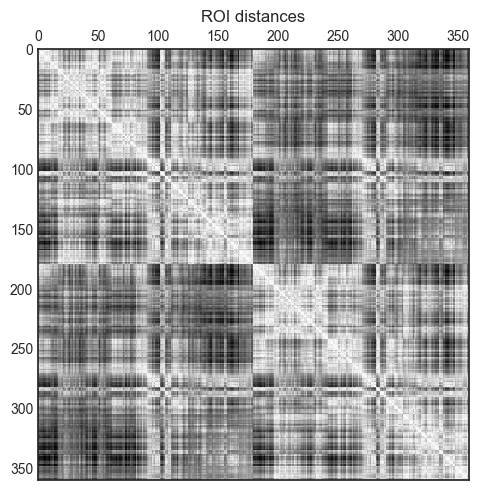

In [7]:
if ED is not None:
    plt.rcParams['figure.figsize'] = [5,5]
    fig, axs = plt.subplots(1, 1, tight_layout=True)
    axs.matshow(ED)
    axs.set_title("ROI distances")

## Correlations

In [8]:
def fill_df(df,mask,ED,SC_L,SC_W):
    if ED is not None:
        df["ED"] = ED[mask].flatten()
    df["SC_W"] = SC_W[mask].flatten()
    #df["SC_W_log"] = SC_W_log[mask].flatten()

    
    if SC_L is not None:
        df["SC_L"] = SC_L[mask].flatten()
        shortest_paths,_ = metrics.distance_wei_floyd(SC_L)
        shortest_path_eff = np.divide(1,shortest_paths)
        df["shortest_path_eff"] = shortest_path_eff[mask].flatten()
    else:
        shortest_paths,_ = metrics.distance_wei_floyd(1/SC_W)
        shortest_path_eff = np.divide(1,shortest_paths)
        df["shortest_path_eff_W"] = shortest_path_eff[mask].flatten()

    com = metrics.communicability_wei(SC_W)
    df["communicability"] = com[mask].flatten()

    if ED is not None:
        SI = metrics.search_information(SC_W,ED)
        df["search_information_ED"] = SI[mask].flatten()

        _,_,nav_paths,_,_ = metrics.navigation_wu(ED, SC_W)
        nav_eff = np.divide(1,nav_paths)
        df["navigation_eff_ED"] = nav_eff[mask].flatten()
    
    if SC_L is not None: # second condition because it was complaining "ndarray is not C-contiguous"
        SI = metrics.search_information(SC_W,SC_L)
        df["search_information_SC_L"] = SI[mask].flatten()

        _,_,nav_paths,_,_ = metrics.navigation_wu(SC_L, SC_W)
        nav_eff = np.divide(1,nav_paths)
        df["navigation_eff_SC_L"] = nav_eff[mask].flatten()        

    _, diff_eff = metrics.diffusion_efficiency(SC_W)
    df["diffusion_eff"] = diff_eff[mask].flatten()

In [9]:
stat_data = {}

for name, SC_W, SC_L, SC_W_log in SC_matrices:
    
    df_probability = pd.DataFrame({"response_probability":response_probability[mask].flatten()})
    df_amplitude = pd.DataFrame({"response_amplitude":response_amplitude[mask_amp].flatten()})

    if SC_L is not None:
        SC_L = np.ascontiguousarray(SC_L)
    SC_W = np.ascontiguousarray(SC_W)

    # supress warnings - all the warnings we saw were about zero division,
    # they result into nans in matrices, but they can not cause any issues
    # (we checked the code where the warnings occured)
    with warnings.catch_warnings(): 
        warnings.simplefilter('ignore')
        fill_df(df_probability,mask,ED,SC_L,SC_W)
        fill_df(df_amplitude,mask_amp,ED,SC_L,SC_W)

    stat_data[name] = {"probability":df_probability,"amplitude":df_amplitude}

In [10]:
def partial_corr_ED(d,x,method):
    result = []
    result.append(pd.DataFrame({"n":0,"r":0,"CI95%":[0,0],"p-val":0,"Y":"ED"})) # just to have fitting images

    for k in d.keys():
        if k == "ED" or k ==x:
            continue
        df_one_result = pg.partial_corr(data=d,x=x,y=k,covar="ED", method=method)
        df_one_result['Y'] = k
        result.append(df_one_result)
    
    return pd.concat(result)

In [11]:
keys = []

result_p = []
result_p_partial = []

result_a = []
result_a_partial = []

for name,_,_,_ in SC_matrices:
    keys.append(name)
    result_p.append(pg.pairwise_corr(stat_data[name]["probability"],columns=["response_probability"], method='spearman').round(3))
    result_a.append(pg.pairwise_corr(stat_data[name]["amplitude"],columns=["response_amplitude"], method='spearman').round(3))
    result_p_partial.append(partial_corr_ED(stat_data[name]["probability"],'response_probability',"spearman"))
    result_a_partial.append(partial_corr_ED(stat_data[name]["amplitude"],"response_amplitude","spearman"))

In [12]:
for r in result_p+result_a+result_p_partial+result_a_partial:
    r['r_abs'] = r['r'].apply(abs)
    #r['CI_size'] = r['CI95%'].apply(lambda x:(x[1]-x[0])/2)
for r in result_p+result_a:
    r['p_sigf'] = r['p-unc'].apply(lambda x: "*" if x< 0.05 else "")
for r in result_p_partial+result_a_partial:
    r['p_sigf'] = r['p-val'].apply(lambda x: "*" if x< 0.05 else "")

result_p = pd.concat(result_p, keys=keys).reset_index(names=["dataset","-"])
result_a = pd.concat(result_a, keys=keys).reset_index(names=["dataset","-"])
result_p_partial = pd.concat(result_p_partial, keys=keys).reset_index(names=["dataset","-"])
result_a_partial = pd.concat(result_a_partial, keys=keys).reset_index(names=["dataset","-"])

In [13]:
plt.style.use('ggplot')
# Set the default color cycle
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=['#E24A33', '#348ABD', '#8EBA42', '#777777','#FBC15E', '#FFB5B8', '#988ED5']) 

In [14]:
def plot_results(d,title):
    plt.figure(figsize=(7,7))
    

    ax = sns.barplot(data=d, x='Y', y='r_abs',hue="dataset")
    ax.set_title(title)  
    ax.set_ylim(bottom=0, top=1)
    ax.tick_params(axis='x', rotation=90)

    # if PARCELLATION == "MNI-HCP-MMP1":
    #     for n,container in zip(keys,ax.containers):
    #         ax.bar_label(container,labels=result_p[result_p["dataset"]==n]["p_sigf"])

    plt.xlabel('Communication metric')
    plt.ylabel('Correlation coefficient')

    plt.show()

def plot_results_overlay(d,d_partial,title):
    plt.figure(figsize=(7,7))

    ax = sns.barplot(data=d, x='Y', y='r_abs',hue="dataset", alpha=0.35,legend=False)

    sns.barplot(data=d_partial, x='Y', y='r_abs',hue="dataset",ax=ax)
    ax.set_title(title)  
    ax.set_ylim(bottom=0, top=1)
    ax.tick_params(axis='x', rotation=90)

    at = AnchoredText("opaque for partiall correlation\ninfluence of ED controlled",frameon=False, loc='upper left')
    at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
    ax.add_artist(at)

    # if PARCELLATION == "MNI-HCP-MMP1":
    #     for n,container in zip(keys,ax.containers):
    #         ax.bar_label(container,labels=result_p_partial[result_p_partial["dataset"]==n]["p_sigf"])

    plt.xlabel('Communication metric')
    plt.ylabel('Correlation coefficient')

    plt.show()

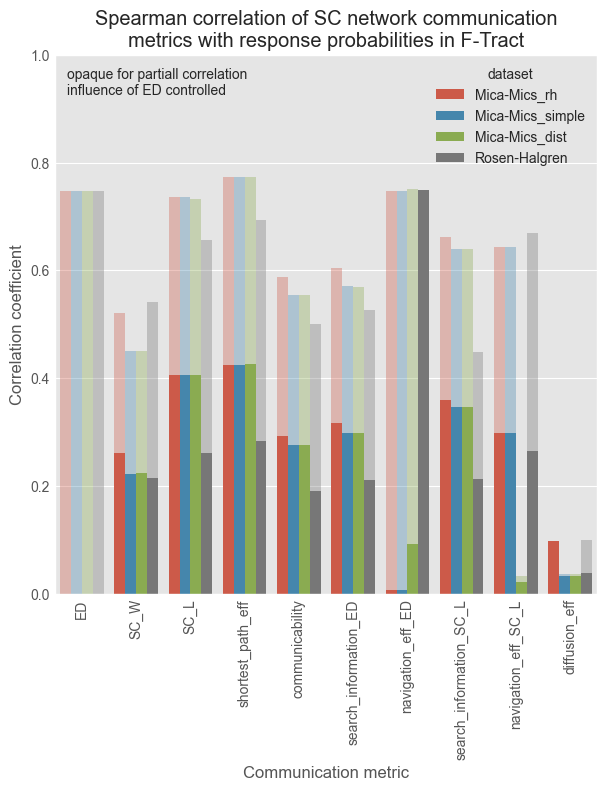

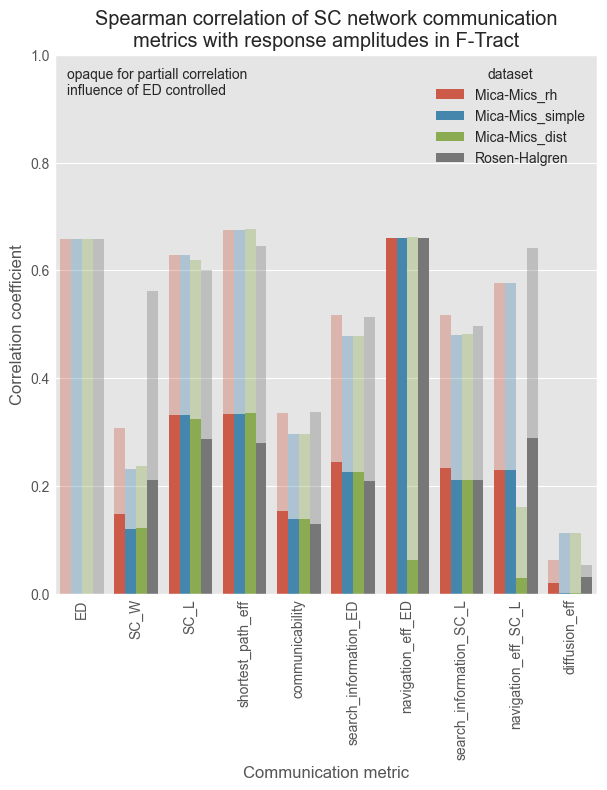

In [15]:
plot_results_overlay(result_p,result_p_partial,title="Spearman correlation of SC network communication\nmetrics with response probabilities in F-Tract")
plot_results_overlay(result_a,result_a_partial,title="Spearman correlation of SC network communication\nmetrics with response amplitudes in F-Tract")

In [16]:
# plot_results(result_p,title="Spearman correlation of SC network communication\nmetrics with response probability in F-Tract")
# plot_results(result_p_partial,title="Partial spearman correlation of SC network communication\nmetrics with response probability in F-Tract (ED controlled)")
# plot_results(result_a,title="Spearman correlation of SC network communication\nmetrics with response amplitude in F-Tract")
# plot_results(result_a_partial,title="Partial spearman correlation of SC network communication\nmetrics with response amplitude in F-Tract (ED controlled)")